# Notes

* Gender (Zero=unknown; 1=male; 2=female)

# Setup

In [1]:
%matplotlib inline

import sklearn as sk
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.tree import export_graphviz

from IPython.display import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
print 'pandas ver: {}'.format(pd.__version__)
print 'scikit learn ver: {}'.format(sk.__version__)

plt.show()
pd.set_option('display.max_columns', 100)
error_reference = {}

# constants
row_axis = 0
col_axis = 1
weekday_map = { 0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}

pandas ver: 0.16.1
scikit learn ver: 0.16.1


# Load processed data

In [22]:
# Citibike station flow - hourly
citibike_single_station_hourlyflow_file_path = '/home/joey/beenverified/02_processed_data/citibike_station495-hourlyflowdata.csv'
citibike_station_hourlyflow = pd.read_csv(citibike_single_station_hourlyflow_file_path)

#setup index to be eastern time column
citibike_station_hourlyflow.set_index(pd.to_datetime(citibike_station_hourlyflow['time'], format='%Y-%m-%d %H:%M:%S'), drop=True, inplace=True)
del citibike_station_hourlyflow['time']
citibike_station_hourlyflow.sort_index(inplace=True)

In [23]:
citibike_station_hourlyflow.shape

(1439, 86)

In [24]:
# preview
citibike_station_hourlyflow[:5]

,inflow,outflow,net,demand,net_class,weekday_idx,weekday,net_class_idx,occupancy,hour_of_day,apparentTemperature,dewPoint,humidity,icon,precipIntensity,precipProbability,pressure,summary,temperature,time.1,visibility,windBearing,windSpeed,cloudCover,precipType,precipAccumulation,icon_simple,summary_idx,icon_idx,icon_simple_idx,icon_simple_clear,icon_simple_cloudy,icon_simple_fog,icon_simple_rain,icon_simple_snow,icon_simple_wind,icon_simple_clear.1,icon_simple_cloudy.1,icon_simple_fog.1,icon_simple_rain.1,icon_simple_snow.1,icon_simple_wind.1,precip_type_rain,precip_type_snow,icon_simple_clear.2,icon_simple_cloudy.2,icon_simple_fog.2,icon_simple_rain.2,icon_simple_snow.2,icon_simple_wind.2,precip_type_rain.1,precip_type_snow.1,icon_simple_clear.3,icon_simple_cloudy.3,icon_simple_fog.3,icon_simple_rain.3,icon_simple_snow.3,icon_simple_wind.3,precip_type_rain.2,precip_type_snow.2,icon_simple_clear.4,icon_simple_cloudy.4,icon_simple_fog.4,icon_simple_rain.4,icon_simple_snow.4,icon_simple_wind.4,precip_type_rain.3,precip_type_snow.3,icon_simple_clear.5,icon_simple_cloudy.5,icon_simple_fog.5,icon_simple_rain.5,icon_simple_snow.5,icon_simple_wind.5,precip_type_none,precip_type_rain.4,precip_type_snow.4,icon_simple_clear.6,icon_simple_cloudy.6,icon_simple_fog.6,icon_simple_rain.6,icon_simple_snow.6,icon_simple_wind.6,precip_type_none.1,precip_type_rain.5,precip_type_snow.5
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,2,0,2,2,producing bikes,4,Fri,2,2,0,32.73,27.51,0.60,clear-night,0,0,1017.15,Clear,40.23,1451642400,10,272,13.13,0.00,none,0,clear,4,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0
2016-01-01 01:00:00,6,0,6,6,producing bikes,4,Fri,2,8,1,32.87,26.81,0.59,clear-night,0,0,1017.49,Clear,40.07,1451646000,10,269,12.17,0.00,none,0,clear,4,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0
2016-01-01 02:00:00,0,0,0,0,balanced flow,4,Fri,0,8,2,32.70,27.22,0.60,partly-cloudy-night,0,0,1017.66,Mostly Cloudy,39.77,1451649600,10,284,11.62,0.84,none,0,cloudy,19,5,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0
2016-01-01 03:00:00,2,0,2,2,producing bikes,4,Fri,2,10,3,32.66,25.12,0.56,clear-day,0,0,1017.66,Clear,39.30,1451653200,10,281,10.25,0.00,none,0,clear,4,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0
2016-01-01 04:00:00,0,0,0,0,balanced flow,4,Fri,0,10,4,32.89,25.51,0.57,clear-day,0,0,1017.90,Clear,39.25,1451656800,10,277,9.61,0.00,none,0,clear,4,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0


# Setup model

## HYPOTHESIS - predict station occupancy given historical data and weather - regression

## 1.0 Baseline

In [67]:
# station flows
model_name = 'baseline'
model_number = 1
target_col = 'occupancy'
feature_cols = ['hour_of_day']

# filter to contain just target and feature data
X = citibike_station_hourlyflow[feature_cols]
Y = citibike_station_hourlyflow[target_col]

## 2.0 Baseline + Day of Week

In [81]:
# station flows
model_name = 'baseline + day of week'
model_number = 2
target_col = 'occupancy'
feature_cols = ['hour_of_day', 'weekday_idx']

# filter to contain just target and feature data
X = citibike_station_hourlyflow[feature_cols]
Y = citibike_station_hourlyflow[target_col]

## 3.0 Baseline + weather

In [94]:
# station flows
model_name = 'baseline + weather'
model_number = 3
target_col = 'occupancy'
feature_cols = ['hour_of_day', 'weekday_idx', 'precipProbability', u'apparentTemperature', u'temperature',
                 u'visibility', u'windBearing', u'windSpeed', u'cloudCover', u'precipAccumulation', u'dewPoint', u'precipIntensity', 
                 u'precipProbability', u'pressure', u'humidity']

# filter to contain just target and feature data
X = citibike_station_hourlyflow[feature_cols]
Y = citibike_station_hourlyflow[target_col]

## 4.0 Improved features

In [106]:
# station flows
model_name = 'improved features'
model_number = 4
target_col = 'occupancy'
feature_cols = ['hour_of_day', u'weekday_idx', 'precipProbability', u'apparentTemperature', u'temperature',
                u'visibility', u'windBearing', u'windSpeed', u'cloudCover', u'precip_type_none', u'precip_type_rain',
                u'precip_type_snow', u'precipAccumulation', u'dewPoint', u'precipIntensity', 
                u'precipProbability', u'pressure', u'humidity', u'icon_simple_clear',
                u'icon_simple_cloudy', u'icon_simple_fog', u'icon_simple_rain',
                u'icon_simple_snow', u'icon_simple_wind']

# filter to contain just target and feature data
X = citibike_station_hourlyflow[feature_cols]
Y = citibike_station_hourlyflow[target_col]

# Train & Test model

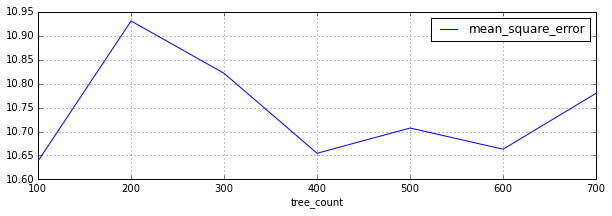

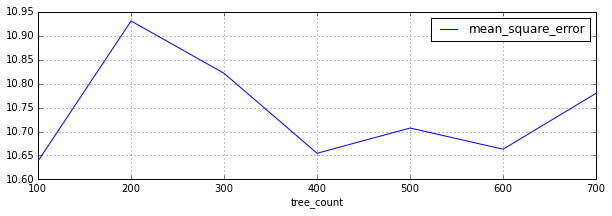

In [107]:
# split the data into train and test.  build the model using the training data, then verify the accuracy using the hold out test set

# config
pct_train_size = 0.8

# split train and test datasets
train_idx = X.sample(frac= pct_train_size)
x_train = X.loc[X.index.isin(train_idx.index)]
x_test = X.loc[~X.index.isin(train_idx.index)]
y_train = Y.loc[Y.index.isin(train_idx.index)]
y_test = Y.loc[~Y.index.isin(train_idx.index)]

#Diagnostics
# check dimensions
# print x_train.shape
# print y_train.shape
# print x_test.shape
# print y_test.shape

# look for na's
#X[X.isnull().any(axis=1)]




# search parameter space to tune random forest
from IPython import display

results = pd.DataFrame([], columns=['tree_count','mean_square_error'])
results = results.set_index('tree_count')

#quick hack to a more formal grid search
for tree_count in range(100,800,100):
    forest = RandomForestRegressor(n_estimators=tree_count, max_features=None, max_depth=30, min_samples_split=1)
    forest = forest.fit(x_train, y_train)

    y_pred = forest.predict(x_test)
    error = mean_squared_error(y_test, y_pred)
    results = results.append( {'tree_count':tree_count, 'mean_square_error':error}, ignore_index=True)
    
#    display.clear_output(wait=True)
results.set_index('tree_count').plot(figsize=(10,3))
display.display(plt.gcf())

# Accuracy assessment - regression

model name: improved features
model number: 4
optimal number of trees 100
test error: 1.1e+01 stdev: 3.3
full dataset error: 3.7 stdev: 1.9
final fit (actual vs pred data)
plot reference: /home/joey/beenverified/03_model_data/4-improved features.png


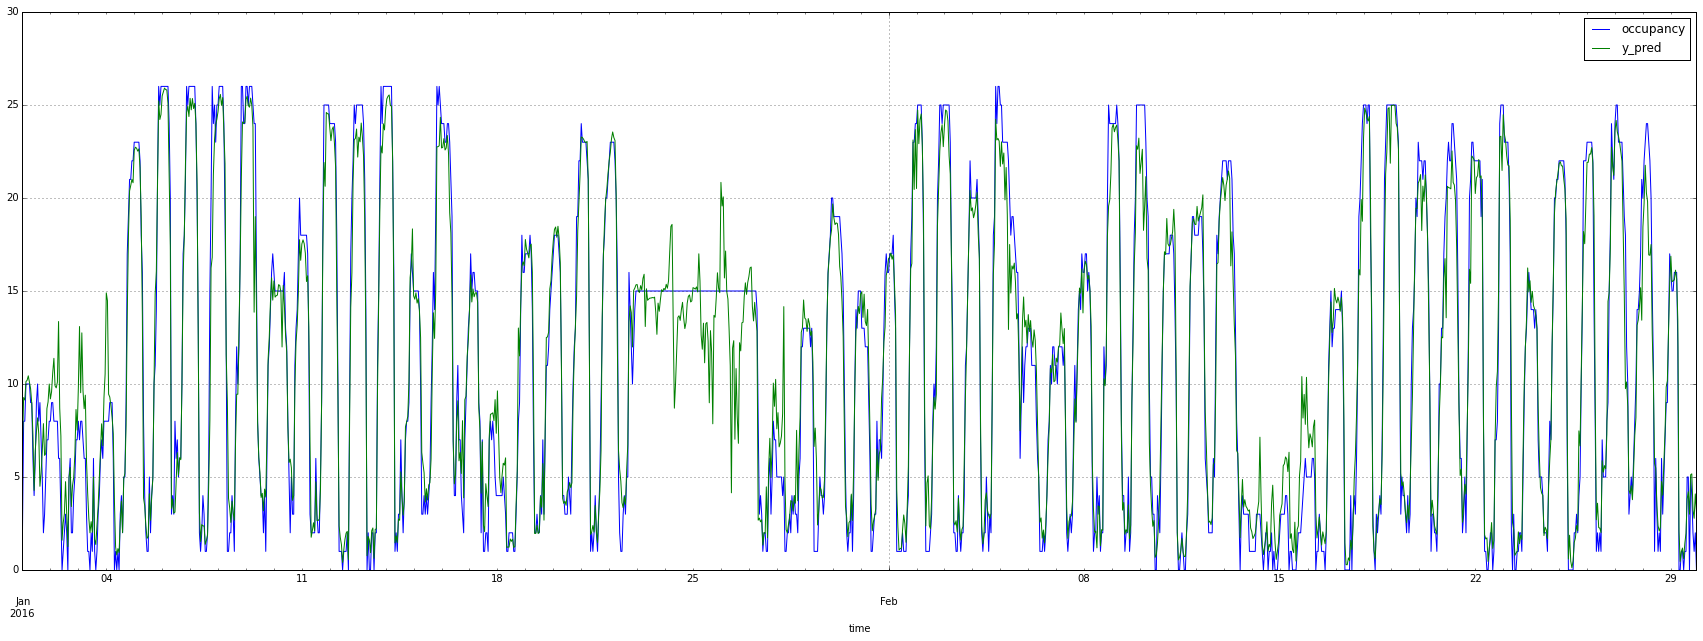

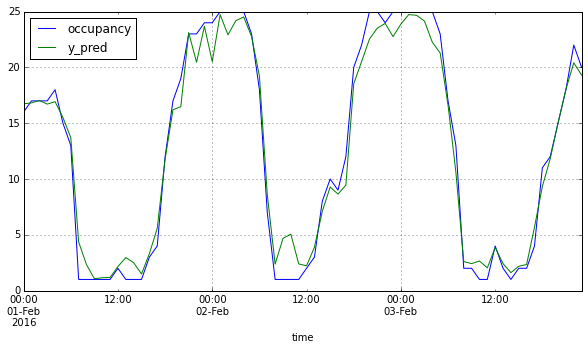

In [108]:
# display min error results and tree count config

display.clear_output(wait=True)
search_min_error_tree_count = int(results[results.index == results['mean_square_error'].idxmin()]['tree_count'].values)
forest = RandomForestRegressor(n_estimators= search_min_error_tree_count, verbose=0)
forest = forest.fit( x_train, y_train)

print 'model name: {}'.format(model_name)
print 'model number: {}'.format(model_number)
print 'optimal number of trees', search_min_error_tree_count

y_pred = forest.predict(x_test)
error = mean_squared_error( y_test, y_pred)
stdev = np.sqrt(error)
print 'test error: {:.2} stdev: {:.2}'.format(error, stdev)

y_pred = forest.predict(X)
error = mean_squared_error(Y, y_pred)
stdev = np.sqrt(error)
print 'full dataset error: {:.2} stdev: {:.2}'.format(error, stdev)

print 'final fit (actual vs pred data)'
toplot = Y.to_frame()
toplot['y_pred'] = forest.predict(X)
toplot.plot(figsize=(30,10))
toplot[(toplot.index >= '2016-02-01') & (toplot.index < '2016-02-04')].plot(figsize=(10,5))
#import matplotlib as plt
save_plot_file = "/home/joey/beenverified/03_model_data/{}-{}.png".format(model_number, model_name)
print 'plot reference: {}'.format(save_plot_file)
plt.savefig(save_plot_file)

# store errors for comparison
error_reference[model_name] = (model_number, error, stdev)

# Features importance

Feature ranking (improved features):
1. feature [hour_of_day]: 0.523
2. feature [dewPoint]: 0.079
3. feature [pressure]: 0.076
4. feature [weekday_idx]: 0.075
5. feature [windBearing]: 0.056
6. feature [apparentTemperature]: 0.044
7. feature [windSpeed]: 0.040
8. feature [humidity]: 0.035
9. feature [temperature]: 0.033
10. feature [visibility]: 0.013
11. feature [cloudCover]: 0.007
12. feature [precipProbability]: 0.004
13. feature [precipProbability]: 0.004
14. feature [precipIntensity]: 0.002
15. feature [icon_simple_cloudy]: 0.002
16. feature [icon_simple_clear]: 0.002
17. feature [precip_type_none]: 0.002
18. feature [icon_simple_wind]: 0.001
19. feature [icon_simple_snow]: 0.001
20. feature [precipAccumulation]: 0.001
21. feature [precip_type_snow]: 0.001
22. feature [precip_type_rain]: 0.001
23. feature [icon_simple_rain]: 0.000
24. feature [icon_simple_fog]: 0.000


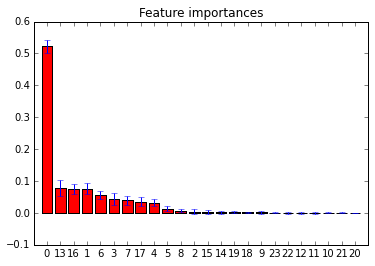

In [109]:
# pull out feature info from random forest
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=row_axis)
indices = np.argsort(importances)[::-1]
feature_names = X.columns

# Print the feature ranking
print("Feature ranking ({}):".format(model_name))
for f in range(X.shape[1]):
    print("{:d}. feature [{}]: {:.3f}".format(f + 1, feature_names[indices[f]], importances[indices[f]]))
    
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

# Summary

# What was done
## Finding a dataset
The first challenge was finding one or more datasets that are interesting and could be used to demonstrate either a predictive or clustering machine learning algorithm.  I reviewed the NYC open data page, looking for dataset with potential for having a recoverable relationship to highlight in this analysis.  I reviewed a hand full of datasets, specifically narrowing the search to a subject matter where I felt I had an intuitive understanding or where questions naturally surfaced.  In the end, Citi Bike data was chosen.  The reason?  Experience with the system and its constraints, and strong curiosity and intuition for how to navigate the dataset.

## Citi Bike data overview
The first task was to review the data published by Citi Bike to get a sense of quality, contents and some inspiration.  My first goal is to jot down some questions and hypotheses for potential predictable relationships to focus an investigation.  Citi Bike publishes historical trip data, aggregate ridership and membership data, and live station feed stats (no history).  I decided to focus on the historical trip data.  The trip data consists of where a bike started and when it ended, including the times and some general non-personally identifiable information on the rider.


## Choosing a Hypothesis
The bike stations occupancy can be predicted based on a time and weather data


## Data preprocessing
### occupancy
First step is to create a target flag, 'occupancy' that we will look to predict.  To reconstruct the historical bike stations occupancy over time, I refactored the data into a timeline of bike station arrival and departure events instead of bike trips.  I picked a familiar station on 47th st to focus on, one that I am familiar commuting from, station ID 495.  I aligned all of the station departure times with the station arrival times and created a new indicator column called 'direction', with a 1 for a bike arriving and -1 for a bike departing.  I then computed the cumulative count of 'direction' over time, to reconstruct the historical dock occupancy.

### weather
Built a script to pull hourly weather data from forecast.io.

### clean up trip data
The first thing I noticed was there was drift in the plot indicating more bikes were entering or leaving than there were docks... most likely this is due to Citi Bike maintenance where a rebalancing, or a number of trip exits were being removed/dropped from the dataset.  After closer inspection I found the same bike entering the station multiple times then leaving only once, or similarly, leaving the station twice with only one reentry.



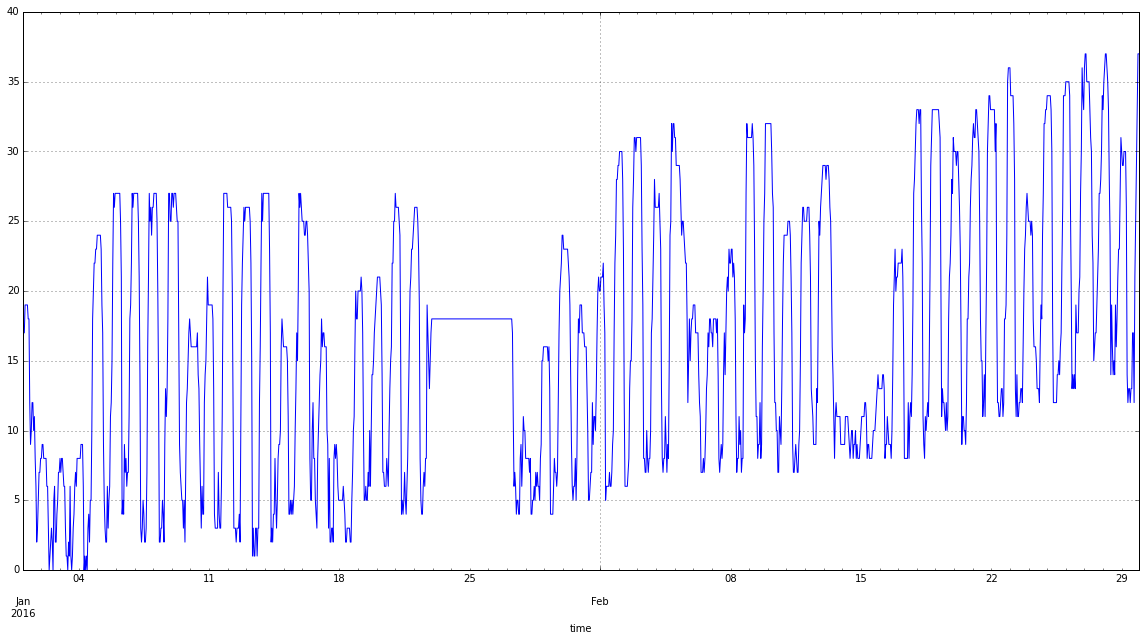

In [36]:
# plot of raw data before cleaning
Image(filename='/home/joey/beenverified/01_raw_data/citibike/PREVIEW - unbalanced trip event data.png')

I was able to find on Citi Bike's website details that they removed trips with a duration <1 minute or >6 hours, as well as test rides, and rebalancing events.  This detail made it quite a bit more challenging to reconstruct the historical station occupancy.  Taking a step back, another way to capture historical bike station occupancy is to query the Citi Bike live station feed, but this would require running a process over some time to collect enough data to be useful, a bit beyond the scope for this project.

To get around this I then went through the records and removed odd numbered counts of bike records by bikeid.  Meaning for each bikeid, you will always find a enter event paired with a leaving event.

More specifically
- single bikeid trips are expected to occur near the edges of the data file, an artifact of partitioning the data into monthly files. these straglers were removed
- odd counts of bikeid's were reviewed, removing any trip where a bike trip was out of place, ie. entering does not have a paired exit event, in that order.  This removed trips where a bike exited before entered, a bike entered multiple times without leaving, a bike left multiple times without entering, etc...

As you can see in the plot of the cleaned data below, the occupancy is now reasonably bounded between a min and max level.  There is still more work to be done, as there are only 25 docks at this bike station and the occupancy chart shows more than 25 bikes at the station on a few days.  For now, understanding why the bike count goes above 25 is left as Citi Bike maintenance noise to be better understood in a future diagnostic investigation.

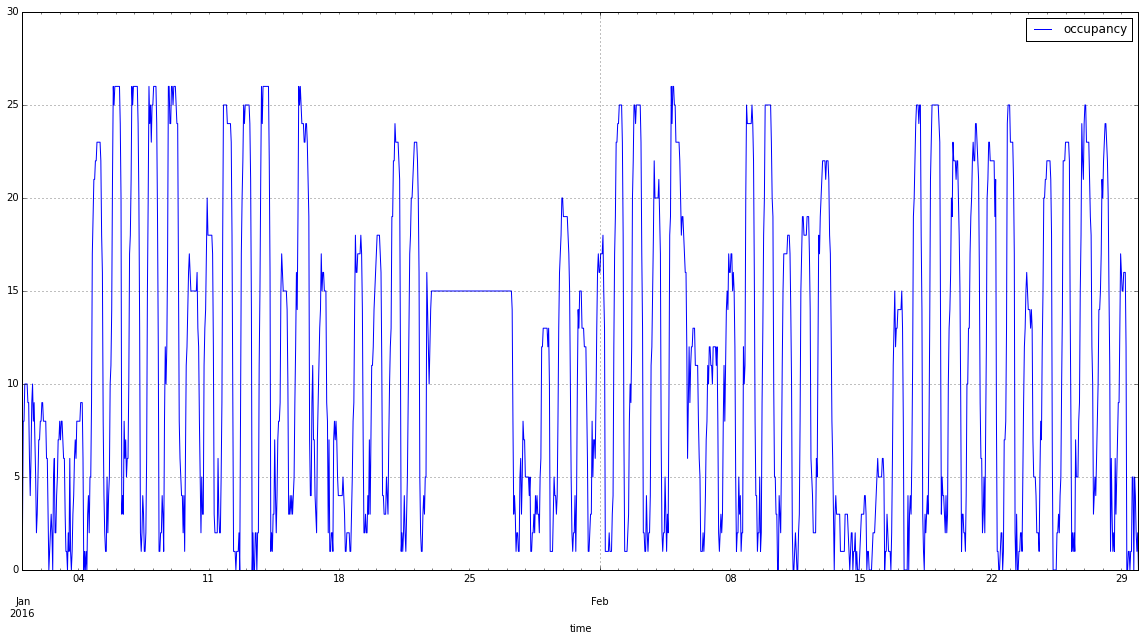

In [37]:
# plot of data after cleaning
citibike_station_hourlyflow[['occupancy']].plot(figsize=(20,10))

In [38]:
#preview of the final cleaned station event data
citibike_station_hourlyflow[:5]

,inflow,outflow,net,demand,net_class,weekday_idx,weekday,net_class_idx,occupancy,hour_of_day,apparentTemperature,dewPoint,humidity,icon,precipIntensity,precipProbability,pressure,summary,temperature,time.1,visibility,windBearing,windSpeed,cloudCover,precipType,precipAccumulation,icon_simple,summary_idx,icon_idx,icon_simple_idx,icon_simple_clear,icon_simple_cloudy,icon_simple_fog,icon_simple_rain,icon_simple_snow,icon_simple_wind,icon_simple_clear.1,icon_simple_cloudy.1,icon_simple_fog.1,icon_simple_rain.1,icon_simple_snow.1,icon_simple_wind.1,precip_type_rain,precip_type_snow,icon_simple_clear.2,icon_simple_cloudy.2,icon_simple_fog.2,icon_simple_rain.2,icon_simple_snow.2,icon_simple_wind.2,precip_type_rain.1,precip_type_snow.1,icon_simple_clear.3,icon_simple_cloudy.3,icon_simple_fog.3,icon_simple_rain.3,icon_simple_snow.3,icon_simple_wind.3,precip_type_rain.2,precip_type_snow.2,icon_simple_clear.4,icon_simple_cloudy.4,icon_simple_fog.4,icon_simple_rain.4,icon_simple_snow.4,icon_simple_wind.4,precip_type_rain.3,precip_type_snow.3,icon_simple_clear.5,icon_simple_cloudy.5,icon_simple_fog.5,icon_simple_rain.5,icon_simple_snow.5,icon_simple_wind.5,precip_type_none,precip_type_rain.4,precip_type_snow.4,icon_simple_clear.6,icon_simple_cloudy.6,icon_simple_fog.6,icon_simple_rain.6,icon_simple_snow.6,icon_simple_wind.6,precip_type_none.1,precip_type_rain.5,precip_type_snow.5
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,2,0,2,2,producing bikes,4,Fri,2,2,0,32.73,27.51,0.60,clear-night,0,0,1017.15,Clear,40.23,1451642400,10,272,13.13,0.00,none,0,clear,4,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0
2016-01-01 01:00:00,6,0,6,6,producing bikes,4,Fri,2,8,1,32.87,26.81,0.59,clear-night,0,0,1017.49,Clear,40.07,1451646000,10,269,12.17,0.00,none,0,clear,4,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0
2016-01-01 02:00:00,0,0,0,0,balanced flow,4,Fri,0,8,2,32.70,27.22,0.60,partly-cloudy-night,0,0,1017.66,Mostly Cloudy,39.77,1451649600,10,284,11.62,0.84,none,0,cloudy,19,5,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0
2016-01-01 03:00:00,2,0,2,2,producing bikes,4,Fri,2,10,3,32.66,25.12,0.56,clear-day,0,0,1017.66,Clear,39.30,1451653200,10,281,10.25,0.00,none,0,clear,4,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0
2016-01-01 04:00:00,0,0,0,0,balanced flow,4,Fri,0,10,4,32.89,25.51,0.57,clear-day,0,0,1017.90,Clear,39.25,1451656800,10,277,9.61,0.00,none,0,clear,4,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0


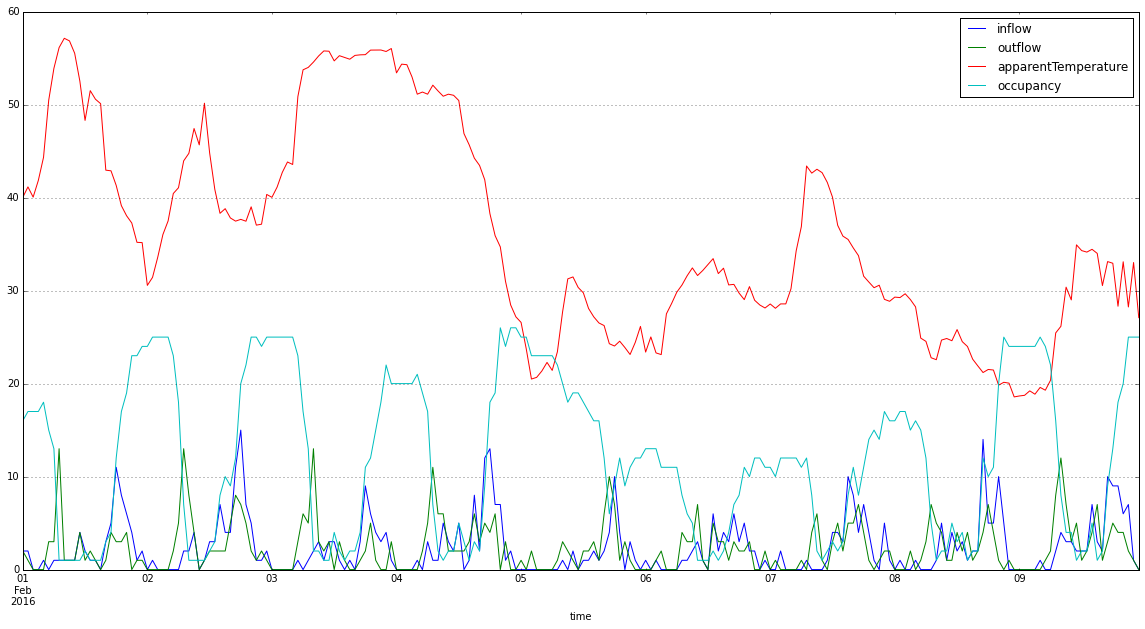

In [42]:
# Preview of final cleaned station occupancy data
filter_rows = (citibike_station_hourlyflow.index >= '2016-02-01 00:00') & (citibike_station_hourlyflow.index < '2016-02-10 00:00')
citibike_station_hourlyflow[filter_rows][['inflow','outflow','apparentTemperature','occupancy']].plot(figsize=(20,10))

# What algorithm or algorithms did you utilize and why?
I chose to use random forest as it generally has robust performance and is forgiving with initial analysis.  It also provides model introspection that allows further insight once the model is built.

## Model building

### 1.0 baseline
On the first model, all I wanted to do was set a baseline for error to benchmark any improvements.  This first model used only the hour of the day to predict the bike station.  In this model there is only one feature, so it is the most important or influential to the prediction ability.

*model name: baseline*
* model number: 1
* optimal number of trees 500
* test error: 3.6e+01 stdev: 6.0
* full dataset error: 3.4e+01 stdev: 5.8
* final fit (actual vs pred data)
* plot reference: /home/joey/beenverified/03_model_data/1-baseline.png

*important features*
Feature ranking (baseline):
1. feature [hour_of_day]: 1.000

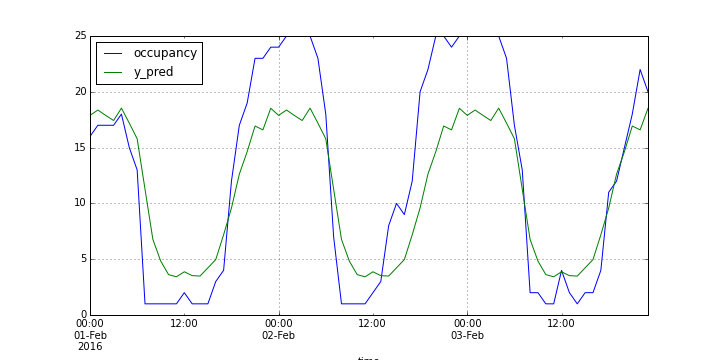

In [87]:
# visual of prediction vs actual values
Image(filename='/home/joey/beenverified/03_model_data/1-baseline.png')

## 2.0 baseline + day of week

For this model I took the baseline (hour per day) and added (weekday).  This helped improve the accuracy with a minor bump.  Out of the two features used, hour of day is more influential to the predictive power than the day of week.

*model name: baseline + day of week*
* model number: 2
* optimal number of trees 600
* test error: 3.5e+01 stdev: 5.9
* full dataset error: 2.8e+01 stdev: 5.3
* final fit (actual vs pred data)
* plot reference: /home/joey/beenverified/03_model_data/2-baseline + day of week.png

*important features*
Feature ranking (baseline + day of week):
1. feature [hour_of_day]: 0.828
2. feature [weekday_idx]: 0.172

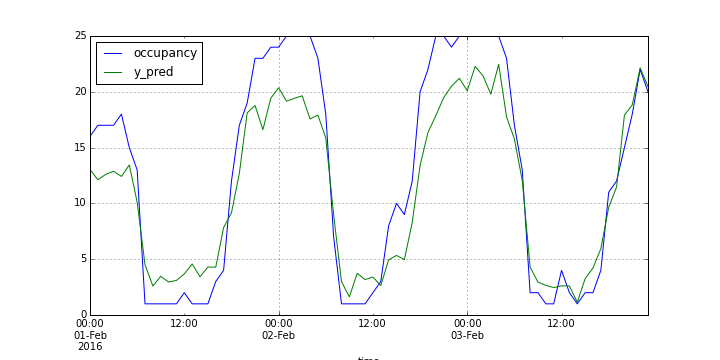

In [88]:
# visual of prediction vs actual values
Image(filename='/home/joey/beenverified/03_model_data/2-baseline + day of week.png')

### 3.0 baseline + weather
This model builds on the previous model by adding weather data from forecast.io.   The addition of weather data was able to significantly bring the stdev prediction error down from 5.3 to 2.0 bikes.  Also notice, the dewPoint feature popped above the day of week feature as having more predictive power, an interesting tidbit.

*model name: baseline + weather*
* model number: 3
* optimal number of trees 300
* test error: 1.3e+01 stdev: 3.6
* full dataset error: 4.0 stdev: 2.0
* final fit (actual vs pred data)
* plot reference: /home/joey/beenverified/03_model_data/3-baseline + weather.png

*important features*
Feature ranking (baseline + weather):
1. feature [hour_of_day]: 0.525
2. feature [dewPoint]: 0.081
3. feature [weekday_idx]: 0.078
4. feature [pressure]: 0.063
5. feature [apparentTemperature]: 0.052
6. feature [windBearing]: 0.052
7. feature [temperature]: 0.042
8. feature [windSpeed]: 0.041
9. feature [humidity]: 0.029
10. feature [visibility]: 0.015
11. feature [cloudCover]: 0.009
12. feature [precipProbability]: 0.004
13. feature [precipIntensity]: 0.003
14. feature [precipProbability]: 0.003
15. feature [precipAccumulation]: 0.001

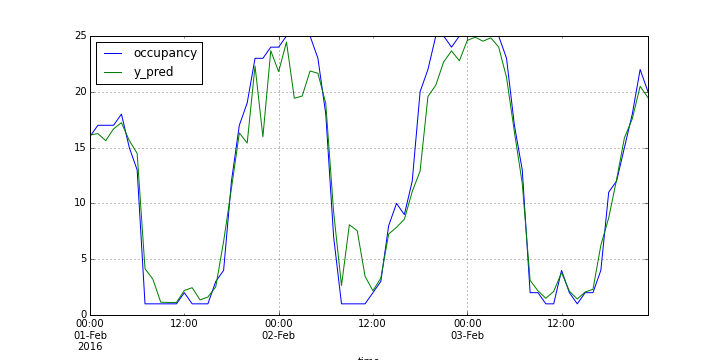

In [99]:
# visual of prediction vs actual values
Image(filename='/home/joey/beenverified/03_model_data/3-baseline + weather.png')

## 4.0 All improved features

This is the final model, including all features created from the Citi Bike and Forecast.io website.  This model has the highest predictive accuracy on the tested dataset of all of the models.  The top predictive features were hour of day, dew point and atmospheric pressure.

*model name: improved features*
* model number: 4
* optimal number of trees 100
* test error: 1.1e+01 stdev: 3.3
* full dataset error: 3.7 stdev: 1.9
* final fit (actual vs pred data)
* plot reference: /home/joey/beenverified/03_model_data/4-improved features.png

*important features*
Feature ranking (improved features):
1. feature [hour_of_day]: 0.523
2. feature [dewPoint]: 0.079
3. feature [pressure]: 0.076
4. feature [weekday_idx]: 0.075
5. feature [windBearing]: 0.056
6. feature [apparentTemperature]: 0.044
7. feature [windSpeed]: 0.040
8. feature [humidity]: 0.035
9. feature [temperature]: 0.033
10. feature [visibility]: 0.013
11. feature [cloudCover]: 0.007
12. feature [precipProbability]: 0.004
13. feature [precipProbability]: 0.004
14. feature [precipIntensity]: 0.002
15. feature [icon_simple_cloudy]: 0.002
16. feature [icon_simple_clear]: 0.002
17. feature [precip_type_none]: 0.002
18. feature [icon_simple_wind]: 0.001
19. feature [icon_simple_snow]: 0.001
20. feature [precipAccumulation]: 0.001
21. feature [precip_type_snow]: 0.001
22. feature [precip_type_rain]: 0.001
23. feature [icon_simple_rain]: 0.000
24. feature [icon_simple_fog]: 0.000

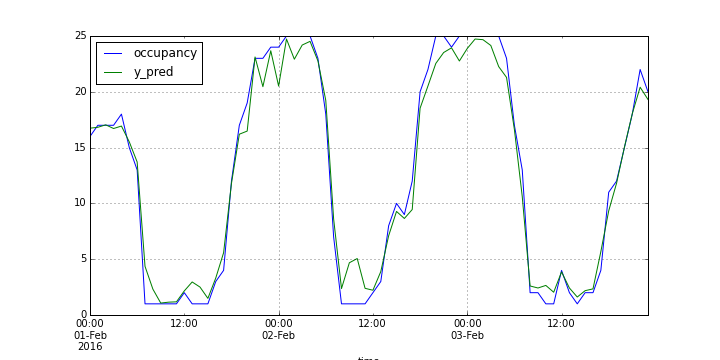

In [110]:
# visual of prediction vs actual values
Image(filename='/home/joey/beenverified/03_model_data/4-improved features.png')

# What is the accuracy of your analysis?
After continuously improving the model accuracy by adding features and optimizing the hyperparameters of the random forest model, I was able to get the final predictive stdev on the test data down from the baseline (+/-)5.8 bikes to about (+/-)1.9 bikes.  The full test dataset runs from 12/1/2015 to 3/1/2016.  See below for more details on the error rates for each predictive model and feature set.

In [120]:
error_history = pd.DataFrame([(x[0], x[1][0], x[1][1], x[1][2]) for x in error_reference.items()], columns=['model_name', 'model_number', 'all data MSE', 'all data stdev']).set_index('model_number').sort_index()
error_history

,model_name,all data MSE,all data stdev
model_number,,,
1,baseline,33.698260,5.805020
2,baseline + day of week,27.579392,5.251608
3,baseline + weather,4.001816,2.000454
4,improved features,3.659678,1.913028


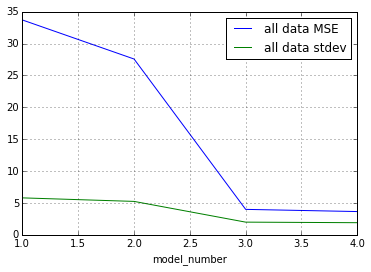

In [121]:
error_history.plot()

# How can you improve upon what you did?
- continue working with the dataset to understand what trips were removed 
- tie in surrounding event data such as parades, street closings, street paving, snow storm, holidays, etc.
- break the prediction problem up into smaller segments where more linear relationships can be uncovered
- predict on higher aggregates of data to increase the signal to noise ratio
- pull in more historical data

# What other approaches would have worked as well?
- building a probabilistic model where uncertainty could be modeled over various time frames or feature characteristics.  This would allow me to highlight the confidence intervals of a given prediction.  For example, if you have two stations you are predicting the occupancy for, but one of the stations is rarely used, and the other has high traffic, the high traffic location will give more confidence around its predictions.

# Resources
* NYC Open Data - nycopendata.socrata.com - used for core Citi Bike dataset
* Statwing - use to quickly explore relationships and get ideas from visuals
* Scikit Learn - machine learning library
* Forecast.io - used to pull weather data